# Assignment 1 – Part C (Final Modelling)
This notebook reproduces all figures and tables needed for Part C and downstream Part D.
**Note:** Keep the CSV file in the same directory or update the path below.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.cluster import KMeans
from scipy import stats

# Global plotting defaults (matplotlib only, one figure per plot)
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.grid'] = True


In [2]:
# Load dataset
CSV_PATH = "AQI_Respiratory_2000_2019.csv"  # Update if needed
assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}"

df_raw = pd.read_csv(CSV_PATH)
print("Shape (raw):", df_raw.shape)
df_raw.head()


Shape (raw): (43472, 20)


/var/folders/np/3yg29yxn7xxfk_4z2c4ts6xh0000gn/T/ipykernel_1288/2855737219.py:5: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(CSV_PATH)


,"FIPS,YEAR",location_name,fips,year,Resp Death Rate,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2_5,Days PM10
0,"1089,2000",Madison County (Alabama),1089.0,2000.0,0.000219,366.0,179.0,151.0,30.0,6.0,0.0,0.0,187.0,100.0,51.0,7.0,0.0,258.0,88.0,13.0
1,"1033,2000",Colbert County (Alabama),1033.0,2000.0,0.000354,106.0,18.0,86.0,2.0,0.0,0.0,0.0,124.0,82.0,63.0,0.0,0.0,0.0,106.0,0.0
2,"1049,2000",DeKalb County (Alabama),1049.0,2000.0,0.000317,354.0,161.0,131.0,58.0,4.0,0.0,0.0,159.0,115.0,54.0,0.0,0.0,291.0,62.0,1.0
3,"1079,2000",Lawrence County (Alabama),1079.0,2000.0,0.000314,272.0,122.0,120.0,29.0,1.0,0.0,0.0,172.0,101.0,54.0,0.0,0.0,202.0,70.0,0.0
4,"1103,2000",Morgan County (Alabama),1103.0,2000.0,0.000320,222.0,69.0,105.0,41.0,7.0,0.0,0.0,187.0,121.0,66.0,0.0,0.0,153.0,55.0,14.0


In [3]:
# Define columns
FEATURES = ['Median AQI', '90th Percentile AQI', 'Max AQI', 'Days PM2_5', 'Days Ozone']
TARGET = 'Resp Death Rate'

# Drop rows with missing values
df = df_raw.dropna(subset=FEATURES + [TARGET]).copy()
print("Shape (clean):", df.shape)

# Keep Year if present for trends
has_year = 'Year' in df.columns

# Split features/target
X = df[FEATURES].values
y = df[TARGET].values.reshape(-1,)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

len(X_train), len(X_test)


Shape (clean): (21028, 20)


(16822, 4206)

In [4]:
# Train models
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

rf = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Baseline (mean predictor)
dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)
y_pred_base = dummy.predict(X_test)

# Metrics
results = pd.DataFrame({
    "Model": ["Baseline (Mean)", "Linear Regression", "Random Forest"],
    "R2": [
        r2_score(y_test, y_pred_base),
        r2_score(y_test, y_pred_lin),
        r2_score(y_test, y_pred_rf)
    ],
    "MSE": [
        mean_squared_error(y_test, y_pred_base),
        mean_squared_error(y_test, y_pred_lin),
        mean_squared_error(y_test, y_pred_rf)
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred_base),
        mean_absolute_error(y_test, y_pred_lin),
        mean_absolute_error(y_test, y_pred_rf)
    ]
})
print(results)
results.to_csv("table2_baseline_vs_models.csv", index=False)


               Model        R2           MSE       MAE
0    Baseline (Mean) -0.000676  7.667321e-09  0.000066
1  Linear Regression  0.045559  7.313061e-09  0.000065
2      Random Forest  0.103488  6.869201e-09  0.000063


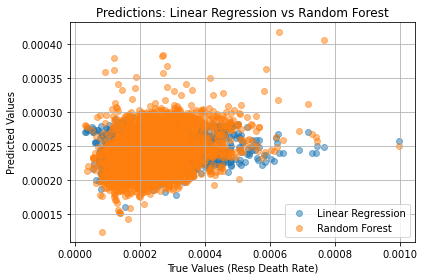

In [5]:
# Figure: Predictions scatter (LR vs RF)
plt.figure()
plt.scatter(y_test, y_pred_lin, alpha=0.5, label='Linear Regression')
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest')
plt.xlabel("True Values (Resp Death Rate)")
plt.ylabel("Predicted Values")
plt.title("Predictions: Linear Regression vs Random Forest")
plt.legend()
plt.tight_layout()
plt.savefig("fig_pred_scatter_lr_rf.png", dpi=200)
plt.show()


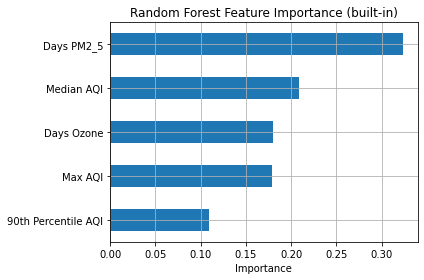

In [6]:
# Figure: Random Forest feature importance (built-in)
fi = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=True)
plt.figure()
fi.plot(kind='barh')
plt.title("Random Forest Feature Importance (built-in)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("fig_feature_importance_builtin.png", dpi=200)
plt.show()


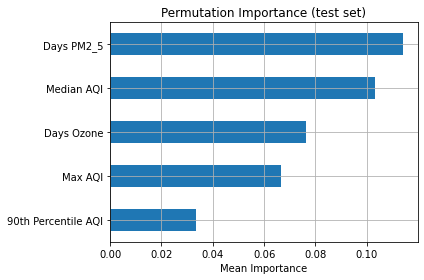

In [7]:
# Figure: Permutation importance (test set)
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
pi = pd.Series(perm.importances_mean, index=FEATURES).sort_values(ascending=True)
plt.figure()
pi.plot(kind='barh')
plt.title("Permutation Importance (test set)")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.savefig("fig_feature_importance_permutation.png", dpi=200)
plt.show()


<Figure size 432x288 with 0 Axes>

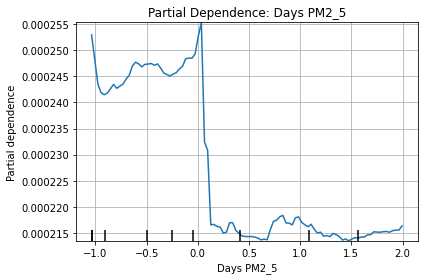

In [8]:
# Figure: Partial Dependence for Days PM2_5 (if present)
if 'Days PM2_5' in FEATURES:
    feat_index = FEATURES.index('Days PM2_5')
    fig = plt.figure()
    PartialDependenceDisplay.from_estimator(rf, X_test, [feat_index], feature_names=FEATURES)
    plt.title("Partial Dependence: Days PM2_5")
    plt.tight_layout()
    plt.savefig("fig_pdp_days_pm25.png", dpi=200)
    plt.show()


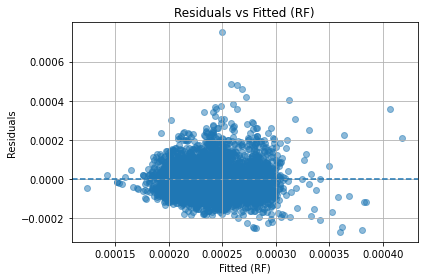

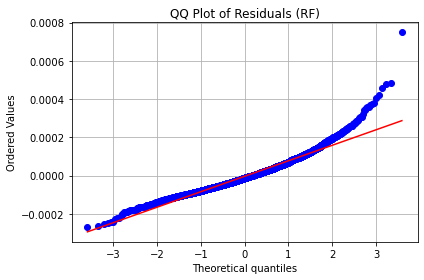

In [9]:
# Figures: Residuals vs Fitted and QQ plot (RF)
residuals = y_test - y_pred_rf
fitted = y_pred_rf

# Residuals vs Fitted
plt.figure()
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Fitted (RF)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (RF)")
plt.tight_layout()
plt.savefig("fig_residuals_vs_fitted_rf.png", dpi=200)
plt.show()

# QQ plot
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (RF)")
plt.tight_layout()
plt.savefig("fig_residuals_qq_rf.png", dpi=200)
plt.show()


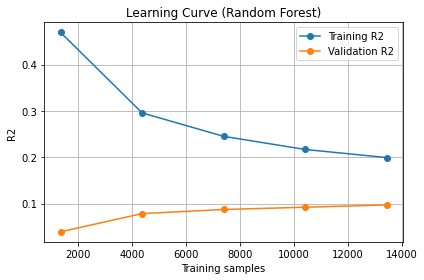

In [10]:
# Figure: Learning curve (RF)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, valid_scores = learning_curve(
    rf, X_train, y_train, cv=cv, scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training R2")
plt.plot(train_sizes, valid_scores.mean(axis=1), marker="o", label="Validation R2")
plt.xlabel("Training samples")
plt.ylabel("R2")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.tight_layout()
plt.savefig("fig_learning_curve_rf.png", dpi=200)
plt.show()


In [11]:
# Figure: Yearly trends (if 'Year' column exists)
if has_year:
    trend = df.groupby('Year').agg({
        'Median AQI': 'median',
        'Resp Death Rate': 'mean'
    }).reset_index()

    plt.figure()
    plt.plot(trend['Year'], trend['Median AQI'], marker='o')
    plt.xlabel("Year")
    plt.ylabel("Median AQI")
    plt.title("Yearly Trend: Median AQI")
    plt.tight_layout()
    plt.savefig("fig_trend_median_aqi.png", dpi=200)
    plt.show()

    plt.figure()
    plt.plot(trend['Year'], trend['Resp Death Rate'], marker='o')
    plt.xlabel("Year")
    plt.ylabel("Resp Death Rate (mean)")
    plt.title("Yearly Trend: Respiratory Death Rate")
    plt.tight_layout()
    plt.savefig("fig_trend_resp_death.png", dpi=200)
    plt.show()
else:
    print("Column 'Year' not found: skipping trends.")


Column 'Year' not found: skipping trends.


/var/folders/np/3yg29yxn7xxfk_4z2c4ts6xh0000gn/T/ipykernel_1288/1077303337.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(im, fraction=0.046, pad=0.04)


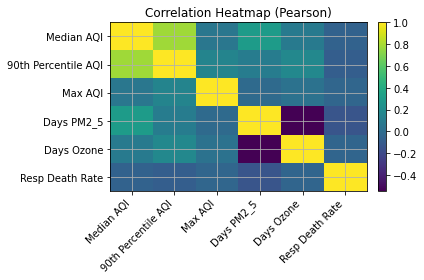

In [12]:
# Figure: Pearson correlation heatmap (AQI features + target)
corr_cols = FEATURES + [TARGET]
corr = df[corr_cols].corr(method='pearson')
plt.figure()
im = plt.imshow(corr, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=np.arange(len(corr_cols)), labels=corr_cols, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(corr_cols)), labels=corr_cols)
plt.title("Correlation Heatmap (Pearson)")
plt.tight_layout()
plt.savefig("fig_corr_heatmap.png", dpi=200)
plt.show()
